In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
def map_sentiment(sentiment):
    if sentiment == 1:
        return 'positif'
    elif sentiment == 0:
        return 'netral'
    else:
        return 'negatif'

In [3]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [4]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [5]:
df = pd.read_csv('sentiment_2700.csv')
df['sentimen'] = df['sentimen'].map(map_sentiment)
df.head(10)

,content,sentimen
0,bacapres koalisi perubahan anies baswedan berb...,positif
1,bacapres koalisi indonesia maju kim prabowo su...,positif
2,bacapres koalisi indonesia maju kim prabowo su...,positif
3,bacapres koalisi perubahan persatuan anies bas...,positif
4,capres mahfud md optimistis ppp parlemen tahun...,positif
5,cawapres koalisi perubahan muhaimin iskandar c...,positif
6,bacapres koalisi pdip ganjar pranowo menanggap...,positif
7,capres koalisi pdip ganjar pranowo khawatir su...,positif
8,capres ganjar pranowo mengaku khawatir preside...,positif
9,capres koalisi perubahan anies baswedan presid...,positif


In [6]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [7]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [8]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

In [9]:
print("Shape of tfidf_train_features:", tfidf_train_features.shape)
print("Length of y_train_encoded:", len(y_train_encoded))

Shape of tfidf_train_features: (1890, 143153)
Length of y_train_encoded: 1890


In [10]:
print("Shape of tfidf_test_features:", tfidf_test_features.shape)
print("Length of y_test_encoded:", len(y_test_encoded))

Shape of tfidf_test_features: (810, 143153)
Length of y_test_encoded: 810


In [11]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

2024-04-14 18:33:49.808131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 18:33:50.798341: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

# Convert text to sequences of numbers
X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences to have the same length
max_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

In [13]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

# Convert text to sequences of numbers
X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences to have the same length
max_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

In [14]:
# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

2024-04-14 18:33:52.800826: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [15]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print("Accuracy:", accuracy)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 398ms/step - accuracy: 0.4241 - loss: 1.0601 - val_accuracy: 0.5247 - val_loss: 0.8933
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 462ms/step - accuracy: 0.5614 - loss: 0.8619 - val_accuracy: 0.5691 - val_loss: 0.8635
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 512ms/step - accuracy: 0.7310 - loss: 0.6581 - val_accuracy: 0.6247 - val_loss: 0.8225
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 520ms/step - accuracy: 0.8370 - loss: 0.4823 - val_accuracy: 0.6457 - val_loss: 0.8450
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 521ms/step - accuracy: 0.8937 - loss: 0.3137 - val_accuracy: 0.6642 - val_loss: 0.9630
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 498ms/step - accuracy: 0.9236 - loss: 0.2179 - val_accuracy: 0.6593 - val_loss: 1.1032
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 460ms/step - accuracy: 0.9508 - loss: 0.1596 - val_accuracy: 0.6358 - val_loss: 1.1123
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 519ms/step - accuracy: 0.9697 - loss: 0.1113 - val_accu

In [19]:
# Classification Report
predictions = np.argmax(model.predict(X_test_padded), axis=-1)
print(classification_report(y_test_encoded, predictions))

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
              precision    recall  f1-score   support

           0       0.68      0.56      0.61       286
           1       0.70      0.79      0.74       252
           2       0.58      0.61      0.59       272

    accuracy                           0.65       810
   macro avg       0.65      0.65      0.65       810
weighted avg       0.65      0.65      0.65       810



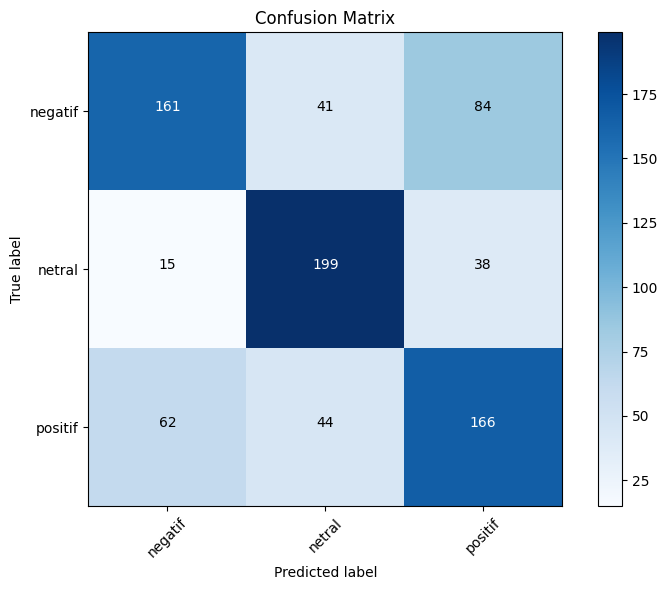

In [20]:
import itertools
# Confusion Matrix
cm = confusion_matrix(y_test_encoded, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

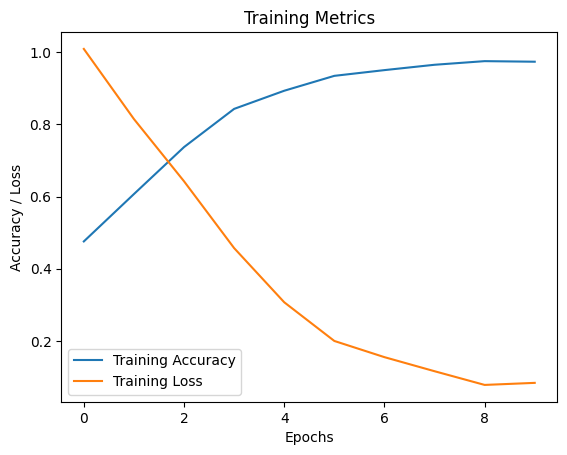

In [21]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Training Metrics')
plt.legend()
plt.show()